**CSI 4506 Introduction à l'intelligence artificielle** <br/>
*Devoir 4: recherche heuristique*

# Identification

Nom : Anass Beharbit <br/> 
Numéro d'étudiant : 300324339


<br/>
<hr/>

## **Aperçu**

Le **problème du voyageur de commerce (TSP)** est un problème fondamental en optimisation. Étant donné un ensemble de villes et les distances entre chaque paire de villes, l'objectif est de calculer le tour le plus court possible qui visite chaque ville exactement une fois avant de revenir au point de départ. Bien que l'énoncé soit simple, l'espace de recherche croît de manière factorielle avec le nombre de villes, rendant la recherche exhaustive infaisable sauf pour de très petites instances.

Le TSP est un problème **NP-difficile**, et aucun algorithme efficace n'est connu pour trouver des solutions optimales à grande échelle. Sa difficulté computationnelle, ainsi que sa pertinence dans la logistique, la fabrication, et la conception de circuits, en ont fait un banc d'essai standard pour évaluer les techniques d'optimisation.

Dans ce devoir, vous allez expérimenter trois approches :

- **Algorithme glouton** — une heuristique simple qui construit un tour en faisant à chaque étape le meilleur choix local.
- **Recuit simulé (SA)** — une technique stochastique inspirée du recuit physique, capable d'échapper aux minima locaux.
- **Algorithme génétique (GA)** — une stratégie évolutive basée sur une population qui affine itérativement les tours candidats.

Votre livrable final est un **cahier Jupyter** présentant vos implémentations, résultats et observations pour chaque méthode.

## **Objectifs d'apprentissage**

- **Mettre en œuvre et expérimenter** plusieurs algorithmes de recherche pour le problème du voyageur de commerce (TSP).
- **Concevoir** une méthode rigoureuse pour choisir la température initiale dans le recuit simulé.
- **Adapter et appliquer** un algorithme génétique pour générer des solutions compétitives au TSP.
- **Analyser et comparer** la performance de toutes les méthodes par rapport aux tours optimaux connus.

## Soumission

- **Date limite :**
   - Soumettez votre devoir avant le 3 décembre, 23h.
- **Travail individuel ou en groupe :**
   - Ce devoir peut être effectué individuellement (groupe de 1 étudiant) ou en collaboration par deux (groupe de 2 étudiants).
   - Un groupe doit soumettre une seule soumission conjointe.
   - Avant de soumettre, il est nécessaire de **s'enregistrer dans un groupe** sur Brightspace.
- **Plateforme de soumission :**
   - Téléverser votre soumission sur Brightspace dans la section Devoirs (Devoir 4).
- **Format de soumission :**
   - Soumettez une copie de votre cahier Jupyter sur Brightspace.

**Avis important :** Assurez-vous que votre cahier Jupyter s'exécute sans erreur dans Google Colab, qui sera notre environnement de référence standard. Bien que vous puissiez choisir de développer votre cahier sur une autre plateforme, il est crucial que votre assistant d'enseignement puisse l'exécuter dans Colab sans avoir à installer des bibliothèques additionnelles ou à transférer des données manuellement. Conservez tous les résultats d'exécution, y compris les graphiques, dans le document afin que votre assistant d'enseignement puisse évaluer votre travail sans avoir besoin d'exécuter des cellules.

## **Jeux de données**

Les jeux de données utilisés dans ce devoir proviennent du [dépôt GitHub TSPLIB](https://github.com/mastqe/tsplib), qui fournit des instances de référence standard pour le problème du voyageur de commerce (TSP). Tous les jeux de données sont **euclidiens**, ce qui signifie que les distances entre les villes sont calculées directement à partir de leurs coordonnées en utilisant la métrique euclidienne.

Pour vos expériences, vous travaillerez avec les jeux de données **berlin52-24-4** et **st70-24**. Chacun est un sous-ensemble de 24 villes extrait de l'instance complète correspondante de TSPLIB. Les bornes inférieures du coût d'un tour pour ces sous-jeux ont été calculées en utilisant la programmation dynamique via l'algorithme de Held–Karp.

1. **berlin52-24-4** :
   - Nombre de villes : 24
   - Coût de la solution optimale : **5890.92**

2. **st70-24-4** :
   - Nombre de villes : 24
   - Coût de la solution optimale : **468.88**

Ces jeux de données sont fournis pour évaluer la performance de vos algorithmes et comparer vos résultats aux solutions optimales connues. Vous pouvez accéder aux données sur GitHub à l'emplacement suivant : [lien](https://github.com/turcotte/csi4106-f25/tree/main/assignments-data/a4). Le sous-dossier `extra` inclut des instances supplémentaires qui peuvent être utiles au fur et à mesure que vous progressez dans le devoir.

Pour la question bonus optionnelle, vous travaillerez avec les deux jeux de données suivants :

3. **berlin52** :
   - Nombre de villes : 52
   - Description : Un jeu de données de taille moyenne avec une distribution spatiale réaliste des villes.
   - Coût de la solution optimale : **7542**

4. **st70** :
   - Nombre de villes : 70
   - Description : Un jeu de données légèrement plus grand avec une complexité accrue.
   - Coût de la solution optimale : **675**<br>
<hr/>

## **0. Code donné**

Voici un Jupyter Notebook présentant des algorithmes gloutons et un algorithme génétique pour résoudre le problème du sac à dos 0/1.

<a target="_blank" href="https://colab.research.google.com/github/turcotte/csi4106-f25/blob/main/notebooks/lectures/20/knapsack.ipynb"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/> </a>

Les deux cours suivants peuvent être utiles pour ce devoir.

- [Cours 18](https://turcotte.xyz/teaching/csi-4106/lectures/18/slides.html) (recuit simulé)
- [Cours 20](https://turcotte.xyz/teaching/csi-4106/lectures/20/slides.html) (algorithme génétique)

### 0.1. Imports

In [15]:
# Les imports nécessaires pour le devoir vont ici :

import numpy as np
import requests
import time

### 0.2. Lire les fichiers TSP

Une fonction pour lire les fichiers TSP depuis un site web.

In [16]:
def read_tsp(url):

    """
    Lit un fichier .tsp à partir d'une URL donnée et renvoie un tableau NumPy de coordonnées.

    Paramètres:
    -----------
    url : str
        L'URL du fichier .tsp.

    Retours:
    --------
    coordinates : ndarray
        Un tableau NumPy de coordonnées extraites du fichier .tsp.

    Description:
    ------------
    Cette fonction récupère le contenu d'un fichier .tsp à partir d'une URL spécifiée et l'analyse pour extraire les coordonnées des villes.
    Elle cherche la section 'NODE_COORD_SECTION' dans le fichier pour commencer la lecture des coordonnées et s'arrête lorsqu'elle atteint 'EOF'.
    La fonction gère les erreurs potentielles en vérifiant le statut de la réponse HTTP et s'assure que les coordonnées sont correctement analysées en nombres à virgule flottante.

    Exemple:
    --------
    >>> url = 'https://raw.githubusercontent.com/turcotte/csi4106-f24/main/assignments-data/a4/berlin52-24-4.tsp'
    >>> coordinates = read_tsp(url)
    >>> print(coordinates)
    [[37.7692, -122.4443],
     [37.7689, -122.4240],
     ...
     [37.7793, -122.4192]]
    """

    try:
        # Récupérer le contenu à partir de l'URL
        response = requests.get(url)
        response.raise_for_status()  # Lève une HTTPError pour les mauvaises réponses (4xx ou 5xx)

        # Diviser le contenu en lignes
        lines = response.text.splitlines()

        # Initialiser une liste pour stocker les coordonnées
        coordinates = []

        # Commencer la lecture après la ligne NODE_COORD_SECTION
        node_section = False
        for line in lines:
            line = line.strip()
            if line == "NODE_COORD_SECTION":
                node_section = True
                continue
            elif line == "EOF":
                break

            if node_section:
                # Diviser la ligne en parties et convertir en flottant
                parts = line.split()
                if len(parts) >= 3:
                    # Certains fichiers incluent des indices de nœuds, donc nous prenons les deux dernières entrées comme coordonnées
                    x, y = float(parts[-2]), float(parts[-1])
                    coordinates.append((x, y))

        # Convertir la liste de coordonnées en tableau NumPy
        return np.array(coordinates)

    except requests.exceptions.RequestException as e:
        print(f"Une erreur s'est produite lors de la récupération du fichier TSP : {e}")
        return None
    except ValueError as e:
        print(f"Une erreur s'est produite lors de l'analyse des coordonnées : {e}")
        return None

In [17]:
URL = 'https://raw.githubusercontent.com/turcotte/csi4106-f25/main/assignments-data/a4/'

berlin52_24_4 = read_tsp(URL + 'berlin52-24-4.tsp')
st70_24_4 = read_tsp(URL + 'st70-24-4.tsp')

La fonction suivante accepte les coordonnées des villes en entrée et produit une matrice de distances.

In [18]:
def get_distance_matrix(coordinates):

    """
        Prend en entrée les coordonnées et renvoie une matrice de distances
        Entrée : coordinates (nn.array) - les coordonnées d'entrée
        Sortie : distance_matrix (np.array) - la matrice de distances (num_cities x num_cities)
    """

    num_cities = len(coordinates)
    distance_matrix = np.zeros((num_cities, num_cities))

    for i in range(num_cities):
        for j in range(num_cities):
            distance_matrix[i][j] = np.linalg.norm(coordinates[i] - coordinates[j])
            
    return distance_matrix 

Les fonctions suivantes peuvent aider à visualiser les résultats et à déboguer vos programmes.

In [19]:
import matplotlib.pyplot as plt

def plot_cities(coordinates, title="Cities in the Traveling Salesman Problem"):

    """
    Trace les coordonnées données représentant les villes.
    
    Paramètres:
    - coordinates: Un tableau NumPy 2D de forme (n, 2) représentant les coordonnées (x, y).
    - title: Titre pour le graphique.
    """

    # Extraire les coordonnées x et y
    x = coordinates[:, 0]
    y = coordinates[:, 1]

    plt.figure(figsize=(6, 6))

    # Tracer les villes comme des points rouges
    plt.scatter(x, y, c='red', zorder=2)

    # Annoter les villes avec leurs indices
    for i, (xi, yi) in enumerate(zip(x, y)):
        plt.annotate(str(i + 1), (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center')

    # Définir le titre et les étiquettes
    plt.title(title)
    plt.xlabel('Coordonnée X')
    plt.ylabel('Coordonnée Y')
    plt.grid(True)
    plt.axis('equal')  # Échelle égale pour les axes x et y
    plt.show()

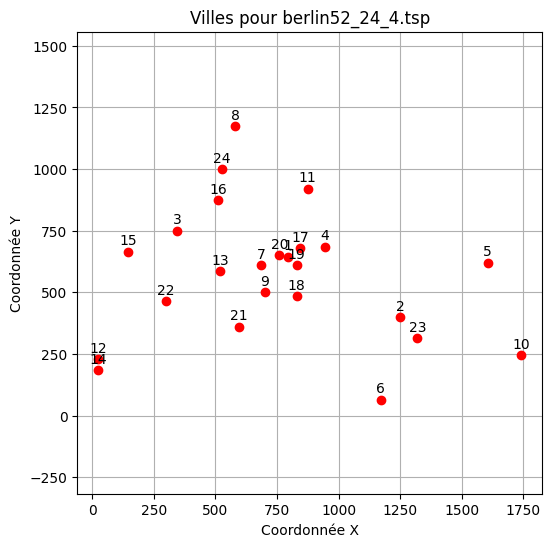

In [20]:
plot_cities(berlin52_24_4, title='Villes pour berlin52_24_4.tsp')

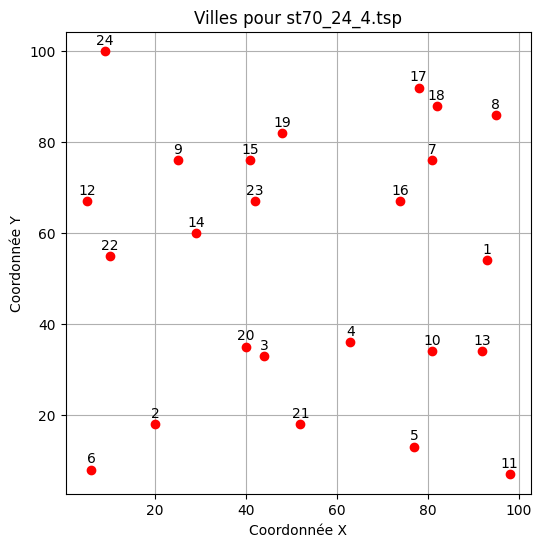

In [21]:
plot_cities(st70_24_4, title='Villes pour st70_24_4.tsp')

In [22]:
def plot_tsp_path(coordinates, path=None, title="Traveling Salesman Problem"):

    """
    Trace les coordonnées données et éventuellement un chemin pour le TSP.
    
    Paramètres:
    - coordinates: Un tableau NumPy 2D de forme (n, 2) représentant les coordonnées (x, y).
    - path: Une liste ou un tableau d'indices représentant l'ordre de visite des nœuds. Si None, les nœuds sont connectés dans l'ordre d'entrée.
    - title: Titre du graphique.
    """

    # Extraire les coordonnées x et y
    x = coordinates[:, 0]
    y = coordinates[:, 1]

    plt.figure(figsize=(6, 6))

    # Si un chemin est donné, réordonner les coordonnées
    if path is not None:
        x = x[path]
        y = y[path]
    
    # Tracer les nœuds
    plt.scatter(x, y, c='red', zorder=2)

    # Annoter les nœuds avec leurs indices
    for i, (xi, yi) in enumerate(zip(x, y)):
        plt.annotate(str(i + 1), (xi, yi), textcoords="offset points", xytext=(0, 5), ha='center')

    # Tracer le chemin
    plt.plot(x, y, 'b-', zorder=1)

    # Si un chemin est fourni, connecter le dernier point au premier pour compléter le tour
    if path is not None:
        plt.plot([x[-1], x[0]], [y[-1], y[0]], 'b-', zorder=1)

    # Définir le titre et les étiquettes
    plt.title(title)
    plt.xlabel('Coordonnée X')
    plt.ylabel('Coordonnée Y')
    plt.grid(True)
    plt.axis('equal')  # Échelle égale pour les axes x et y
    plt.show()

<hr/>

## 1. Implémenter les algorithmes

### 1.1. Implémenter un solveur glouton pour le TSP

L'**heuristique du plus proche voisin** est une stratégie gloutonne simple pour construire un tour TSP faisable.

- En partant d'une ville choisie, l'algorithme sélectionne à plusieurs reprises la ville non visitée la plus proche jusqu'à ce que toutes les villes aient été visitées, puis retourne au point de départ.
  - Si deux villes sont à égale distance, les égalités peuvent être rompues arbitrairement.
- Cette procédure est exécutée une fois pour chaque ville de départ possible, produisant $N$ tours candidats pour une instance avec $N$ villes. Le plus court de ces $N$ tours est conservé.
- À chaque étape, seuls les mouvements valides sont pris en compte, garantissant que chaque tour visite chaque ville exactement une fois.

Votre implémentation doit retourner **à la fois** le tour (sous forme de liste d'indices de villes) **et** sa distance totale.

Bien que cette heuristique soit rapide et produise toujours un tour valide, elle ne garantit pas l'optimalité.

In [23]:
def greedy_tsp(distance_matrix, start_city=0):

    """
    Algorithme glouton pour le problème du voyageur de commerce utilisant l'heuristique du plus proche voisin.

    Args:
        distance_matrix (np.ndarray): Matrice des distances entre les villes.
        start_city (int): Index de la ville de départ.

    Returns:
        tuple: Meilleur tour (liste d'indices de villes) et distance totale.
    """

    num_cities = distance_matrix.shape[0]

    visited = np.zeros(num_cities, dtype=bool)
    tour = [start_city]
    visited[start_city] = True
    current_city = start_city
    total_distance = 0.0

    # On ajoute les villes une par une
    for _ in range(num_cities - 1):
        # On regarde toutes les villes non encore visitées
        distances_from_current = distance_matrix[current_city].copy()
        distances_from_current[visited] = np.inf  # on ignore les villes déjà visitées

        # Plus proche voisin non visité
        next_city = np.argmin(distances_from_current)

        tour.append(int(next_city))
        total_distance += distance_matrix[current_city, next_city]
        visited[next_city] = True
        current_city = next_city

    # Retour à la ville de départ pour fermer le tour
    total_distance += distance_matrix[current_city, start_city]

    return tour, total_distance


In [24]:
def greedy_tsp_do_all(distance_matrix):

    """
    Exécute l'heuristique gloutonne du TSP une fois à partir de chaque ville de départ possible
    et retourne le meilleur tour trouvé.

    Args:
        distance_matrix (np.ndarray): Matrice des distances entre les villes.

    Returns:
        tuple: Meilleur tour (liste d'indices de villes) et sa distance totale.
    """

    num_cities = distance_matrix.shape[0]

    best_tour = None
    best_distance = np.inf

    for start_city in range(num_cities):
        tour, total_distance = greedy_tsp(distance_matrix, start_city=start_city)

        if total_distance < best_distance:
            best_distance = total_distance
            best_tour = tour

    return best_tour, best_distance


### 1.2. Implémenter un solveur TSP utilisant le recuit simulé

Dans l'implémentation du recuit simulé (SA) fournie, vous devez **compléter la méthode `get_initial_temperature`** en concevant une stratégie pour sélectionner une température de départ appropriée.

Votre objectif est de choisir une température initiale telle que le **taux d'acceptation des mouvements proposés** (acceptés / proposés) soit d'environ **60 % à 80 %** lorsqu'il est testé sur un petit échantillon de mouvements aléatoires.

**Suggestions :**

- **Approche basée sur l'échantillonnage :**  
  Générez un tour aléatoire et proposez un ensemble de mouvements voisins aléatoires (par exemple, 10–50). Sélectionnez une température qui donne un taux d'acceptation dans la plage de 60 % à 80 %.

- **Approche de pré-exécution :**  
  Effectuez une courte pré-exécution de la boucle de mise à jour du SA (par exemple, 20–100 mouvements), en réduisant progressivement la température jusqu'à ce que le taux d'acceptation atteigne 60 % à 80 %. Après avoir déterminé cette température, **redémarrez l'exécution principale du SA** à partir de zéro en utilisant cette valeur.

Utilisez la même règle d'acceptation implémentée dans le code SA fourni (`exp(-ΔE / T)` pour les mouvements défavorables). Votre température doit seulement approcher la plage cible ; une correspondance exacte n'est pas requise.

In [25]:
def calculate_total_distance(route, distance_matrix):

    """
    Calculer la distance totale d'un itinéraire donné basé sur la matrice de distances.

    Paramètres:
    -----------
    route : ndarray
        Un tableau représentant l'ordre des villes dans l'itinéraire (une permutation des indices des villes).
    distance_matrix : ndarray
        Une matrice carrée où l'entrée (i, j) représente la distance entre la ville i et la ville j.

    Retours:
    --------
    total_distance : float
        La distance totale de l'itinéraire, y compris le retour à la ville de départ.

    Description:
    ------------
    La fonction calcule la somme des distances entre les villes consécutives dans l'itinéraire
    et ajoute la distance de la dernière ville à la première pour compléter le tour.
    Elle suppose que la matrice de distances est symétrique et non-négative.
    """
    
    total_distance = 0

    for i in range(len(route) - 1):
        total_distance += distance_matrix[route[i], route[i + 1]]

    total_distance += distance_matrix[route[-1], route[0]]  # Retour au départ

    return total_distance

In [27]:
def get_neighbor(route):

    """
    Générer une solution voisine en inversant un segment aléatoire de l'itinéraire.

    Paramètres:
    -----------
    route : ndarray
        Un tableau représentant l'itinéraire actuel (une permutation des indices des villes).

    Retours:
    --------
    new_route : ndarray
        Un nouvel itinéraire obtenu en inversant le segment entre deux indices choisis aléatoirement.

    Description:
    ------------
    Cette méthode sélectionne deux indices aléatoires, `a` et `b`, dans l'itinéraire et inverse le
    segment entre eux (inclusivement). Elle est couramment utilisée dans les algorithmes d'optimisation
    comme le Recuit Simulé pour explorer des solutions voisines dans l'espace de recherche.
    """

    a, b = np.random.randint(0, len(route), size=2)

    if a > b:
        a, b = b, a

    new_route = route.copy()
    new_route[a:b+1] = new_route[a:b+1][::-1]  # Inverser le segment entre a et b
    
    return new_route

Complétez l'implémentation de la méthode `get_initial_temperature`. Vous pouvez introduire des paramètres supplémentaires dans la définition de la fonction si nécessaire ; assurez-vous que toutes les modifications sont reflétées de manière cohérente dans toutes les méthodes qui invoquent cette fonction.

In [ ]:
def get_initial_temperature(distance_matrix, num_samples=50, target_accept=0.7):

    """
    Estimez une température initiale pour l'algorithme de Recuit Simulé.

    Paramètres:
    -----------
    distance_matrix : ndarray
        Une matrice carrée où l'entrée (i, j) représente la distance entre la ville i et la ville j.
    num_samples : int
        Nombre de mouvements aléatoires utilisés pour estimer la température.
    target_accept : float
        Taux d'acceptation visé pour les mouvements défavorables (entre 0 et 1).

    Renvoie:
    --------
    initial_temp : float
        La température initiale estimée pour atteindre le taux d'acceptation spécifié.
    """

    num_cities = distance_matrix.shape[0]

    # Générer un tour aléatoire de départ
    route = np.arange(num_cities)
    np.random.shuffle(route)
    current_cost = calculate_total_distance(route, distance_matrix)

    uphill_deltas = []

    # On génère des voisins
    for _ in range(num_samples):
        neighbor = get_neighbor(route)
        neighbor_cost = calculate_total_distance(neighbor, distance_matrix)
        delta = neighbor_cost - current_cost

        if delta > 0:
            uphill_deltas.append(delta)

        # On avance sur le voisin pour explorer un peu l'espace
        route = neighbor
        current_cost = neighbor_cost

    # Si aucun mouvement défavorable trouvé, on met une valeur par défaut
    if len(uphill_deltas) == 0:
        return 1.0

    mean_delta = np.mean(uphill_deltas)

    # On veut en moyenne :
    initial_temp = - mean_delta / np.log(target_accept)

    # Sécurité au cas où (numériquement instable)
    if initial_temp <= 0 or np.isnan(initial_temp) or np.isinf(initial_temp):
        initial_temp = 1.0

    return initial_temp


In [29]:
def simulated_annealing(distance_matrix, initial_temp, cooling_rate, max_iterations):

    """
    Effectuer l'algorithme de recuit simulé pour approcher une solution au problème du voyageur de commerce (TSP).

    Paramètres :
    ------------
    distance_matrix : ndarray
        Une matrice carrée où l'entrée (i, j) représente la distance entre la ville i et la ville j.
    initial_temp : float
        La température initiale pour le processus de recuit.
    cooling_rate : float
        Le taux auquel la température diminue, généralement une valeur entre 0 et 1.
    max_iterations : int
        Le nombre maximal d'itérations à effectuer.

    Retours :
    ---------
    best_route : ndarray
        L'ordre des villes dans le meilleur (plus court) itinéraire trouvé.
    best_cost : float
        La distance totale du meilleur itinéraire.
    temperatures : list
        Une liste de valeurs de température à chaque itération, utile pour l'analyse ou le traçage.
    costs : list
        Une liste des coûts des itinéraires (distances) à chaque itération, utile pour l'analyse ou le traçage.

    Description :
    ------------
    Le Recuit Simulé (RS) est un algorithme d'optimisation probabiliste inspiré par le processus de recuit en métallurgie.
    Cette implémentation :
    - Commence avec un itinéraire aléatoire et l'améliore de façon itérative.
    - Accepte des solutions moins bonnes avec une probabilité dépendante de la température pour échapper aux minima locaux.
    - Réduit progressivement la température pour se concentrer sur l'exploitation à mesure que l'algorithme progresse.
    - Retourne le meilleur itinéraire trouvé avec des données intermédiaires pour l'analyse.
    """

    num_cities = len(distance_matrix)
    current_route = np.arange(num_cities)
    np.random.shuffle(current_route)
    current_cost = calculate_total_distance(current_route, distance_matrix)
    
    best_route = current_route.copy()
    best_cost = current_cost

    temperatures = []
    costs = []

    temperature = initial_temp

    for iteration in range(max_iterations):

        neighbor_route = get_neighbor(current_route)
        neighbor_cost = calculate_total_distance(neighbor_route, distance_matrix)
        
        # Accepter le voisin s'il est meilleur, ou avec une probabilité s'il est pire
        if neighbor_cost < current_cost or np.random.rand() < np.exp(-(neighbor_cost - current_cost) / temperature):
            current_route = neighbor_route
            current_cost = neighbor_cost

            if current_cost < best_cost:
                best_route = current_route.copy()
                best_cost = current_cost

        # Enregistrer la température et le coût pour le traçage
        temperatures.append(temperature)
        costs.append(current_cost)

        # Refroidir la température
        temperature *= cooling_rate

    return best_route, best_cost, temperatures, costs

In [30]:
def simulated_annealing_do_n(distance_matrix, initial_temp, cooling_rate=0.995, max_iterations=1000, repeats=10):

    """
    Effectuer un recuit simulé plusieurs fois et retourner le meilleur résultat parmi toutes les exécutions.

    Paramètres :
    -----------
    distance_matrix : ndarray
        Une matrice carrée où l'entrée (i, j) représente la distance entre la ville i et la ville j.
    initial_temp : float
        La température initiale pour le processus de recuit.
    cooling_rate : float
        Le taux auquel la température diminue, typiquement une valeur entre 0 et 1.
    max_iterations : int
        Le nombre maximum d'itérations pour chaque exécution de recuit simulé.
    repeats : int
        Le nombre de fois à répéter le processus de recuit simulé.

    Renvoie :
    --------
    best_tour : ndarray
        L'ordre des villes dans le meilleur (le plus court) circuit trouvé parmi toutes les exécutions.
    best_distance : float
        La distance totale du meilleur circuit.
    best_temperatures : list
        Une liste de valeurs de température de la meilleure exécution, utile pour l'analyse ou le traçage.
    best_costs : list
        Une liste des coûts de parcours (distances) de la meilleure exécution, utile pour l'analyse ou le traçage.

    Remarques :
    ------
    Cette méthode utilise la fonction `simulated_annealing` pour effectuer des exécutions d'optimisation individuelles. 
    En répétant le processus plusieurs fois, elle augmente la probabilité de trouver une solution globalement optimale ou quasi-optimale.
    """

    results = [
        simulated_annealing(distance_matrix, initial_temp, cooling_rate, max_iterations)
        for _ in range(repeats)
    ]

    # Trouver le meilleur résultat en minimisant la distance
    best_tour, best_distance, best_temperatures, best_costs = min(results, key=lambda x: x[1])

    return best_tour, best_distance, best_temperatures, best_costs

Les fonctions suivantes peuvent aider à visualiser les résultats et à déboguer vos programmes.

In [31]:
def plot_temperature_and_cost(temperatures, costs):

    """
    Tracez les valeurs de température et de coût au fil des itérations dans un graphique côte à côte.

    Paramètres:
    -----------
    temperatures : liste ou ndarray
        Une séquence de valeurs de température enregistrées à chaque itération d'un algorithme (par exemple, recuit simulé).
    costs : liste ou ndarray
        Une séquence de valeurs de coût (par exemple, distance totale ou énergie) enregistrées à chaque itération.

    Description:
    ------------
    Cette fonction génère deux sous-graphiques:
    1. **Température au fil des itérations** : Tracez comment la température change au fil du temps, ce qui est utile pour visualiser le programme de refroidissement dans des algorithmes comme le recuit simulé.
    2. **Coût au fil des itérations** : Tracez le coût (par exemple, distance totale dans le TSP) à chaque itération, montrant comment la solution s'améliore au fil du temps.

    Les graphiques sont disposés côte à côte pour une comparaison facile entre le programme de température et la progression correspondante du coût. La fonction ajuste la mise en page pour un meilleur espacement et affiche la figure combinée.

    Exemple:
    --------
    >>> plot_temperature_and_cost(temperatures, costs)

    Remarques:
    ------
    - Assurez-vous que les longueurs de `temperatures` et `costs` sont égales, correspondant au nombre d'itérations.
    - Nécessite que `matplotlib.pyplot` soit importé en tant que `plt` avant d'appeler cette fonction.
    """
    
    # Tracez les graphiques de température et de coût
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(temperatures)
    plt.title("Température au fil des itérations")
    plt.xlabel("Itération")
    plt.ylabel("Température")

    plt.subplot(1, 2, 2)
    plt.plot(costs)
    plt.title("Coût au fil des itérations")
    plt.xlabel("Itération")
    plt.ylabel("Coût")

    plt.tight_layout()
    plt.show()

### 1.3. Implémenter un solveur pour le TSP en utilisant un algorithme génétique

Une implémentation partielle d'un **algorithme génétique (GA)** pour le TSP est fournie. Votre tâche est de compléter trois composants clés tout en vous assurant que tous les tours restent des permutations valides des villes.

Un GA suit les étapes suivantes :

1. **Initialisation** – Générer une population initiale de tours valides aléatoires.
2. **Évaluation** – Calculer la distance totale de chaque tour et attribuer des valeurs de fitness.
3. **Élitisme** – Copier les meilleurs individus directement dans la génération suivante.
4. **Sélection** – Sélectionner les parents (par exemple, sélection par tournoi ou par roulette).
5. **Croisement** – Produire des enfants en recombinant les parents à l'aide d'un opérateur de croisement préservant les permutations.
6. **Mutation** – Introduire de la variation en appliquant un opérateur de mutation qui maintient des permutations valides.
7. **Remplacement** – Former la génération suivante en utilisant les élites et la descendance.
8. Répéter les étapes 2 à 7 pour un nombre fixe de générations.

Vous devez implémenter les trois fonctions suivantes dans le code fourni :

* `evaluate_fitness(population, distance_matrix)`
* `crossover_operator(parent1, parent2)`
* `mutation(offspring, mutation_rate)`

Directives :

- Vous n'avez **pas** besoin de modifier les docstrings fournies ; implémentez seulement le corps des fonctions.
- **Fitness :** Calculez le fitness comme l'inverse de la distance du tour (par exemple, `1 / (distance + 1e-6)`).
- **Croisement :** Vous pouvez utiliser n'importe quel croisement préservant les permutations (par exemple, OX, PMX, CX). L'enfant résultant doit être un tour valide.
- **Mutation :** Utilisez toute mutation préservant les permutations (par exemple, échange, inversion, insertion).
- **Validité :** Tous les individus de chaque génération doivent rester des permutations valides des villes (chaque ville apparaît exactement une fois).

Dans l'implémentation ci-dessous, total_distances est utilisé pour le rapport des résultats, tandis que le fitness est utilisé en interne par l'AG pour la sélection.

In [32]:
def initialize_population(pop_size, num_cities):

    """
    Générer une population initiale de parcours aléatoires pour un algorithme génétique.

    Paramètres:
    -----------
    pop_size : int
        Le nombre d'individus (parcours) dans la population.
    num_cities : int
        Le nombre de villes dans le problème du voyageur de commerce (TSP).

    Retours:
    --------
    population : ndarray
        Un tableau 2D de forme (pop_size, num_cities), où chaque ligne représente
        une permutation aléatoire des indices de ville (une solution potentielle).

    Description:
    ------------
    Cette fonction initialise une population en créant `pop_size` permutations aléatoires
    des indices de ville, assurant la diversité des solutions initiales. Chaque individu
    représente un parcours valide pour le TSP.
    """
    
    return np.array([np.random.permutation(num_cities) for _ in range(pop_size)])

Complétez l'implémentation de la méthode `evaluate_fitness`.

In [33]:
def evaluate_fitness(population, distance_matrix):

    """
    Évaluez la valeur d'aptitude de chaque individu dans une population pour un algorithme génétique.

    Paramètres:
    -----------
    population : ndarray
        Un tableau 2D où chaque ligne représente un itinéraire individuel (une permutation des indices des villes).
    distance_matrix : ndarray
        Une matrice carrée où l'entrée (i, j) représente la distance entre la ville i et la ville j.

    Retours:
    --------
    fitness : ndarray
        Un tableau 1D contenant les valeurs d'aptitude pour chaque individu dans la population.
        L'aptitude est calculée comme l'inverse de la distance totale de l'itinéraire.
    total_distances : ndarray
        Un tableau 1D contenant les distances totales des itinéraires pour chaque individu.
    """

    pop_size = population.shape[0]
    total_distances = np.zeros(pop_size, dtype=float)

    # Calcul de la distance totale pour chaque individu
    for i in range(pop_size):
        route = population[i]
        total_distances[i] = calculate_total_distance(route, distance_matrix)

    # Fitness = 1 / distance (plus la tournée est courte, plus la fitness est grande)
    # On ajoute une petite constante pour éviter la division par zéro.
    fitness = 1.0 / (total_distances + 1e-6)

    return fitness, total_distances


In [34]:
def tournament_selection(population, fitness, tournament_size):

    """
    Effectuer une sélection par tournoi pour choisir des individus pour la prochaine génération dans un Algorithme Génétique.

    Paramètres:
    -----------
    population : ndarray
        Un tableau 2D où chaque ligne représente un individu (une solution potentielle).
    fitness : ndarray
        Un tableau 1D contenant les valeurs de fitness des individus dans la population.
    tournament_size : int
        Le nombre d'individus sélectionnés aléatoirement pour chaque tournoi.

    Renvoie:
    --------
    selected_population : ndarray
        Un tableau 2D de la même forme que `population`, contenant les individus sélectionnés
        pour la prochaine génération.

    Description:
    ------------
    La sélection par tournoi fonctionne comme suit :
    1. Pour chaque individu à sélectionner, choisir aléatoirement `tournament_size` participants de la population.
    2. Comparer leurs valeurs de fitness et sélectionner l'individu avec la meilleure fitness.
    3. Répéter ce processus jusqu'à ce qu'une nouvelle population de la même taille que l'original soit formée.

    Cette méthode équilibre l'exploitation (choisir les meilleurs individus) avec l'exploration (sélection aléatoire
    des participants), permettant à l'algorithme de se concentrer sur des solutions de haute qualité tout en maintenant la diversité.
    """

    pop_size = population.shape[0]
    selected_indices = []
    
    for _ in range(pop_size):

        participants = np.random.choice(pop_size, tournament_size, replace=False)
        best = participants[np.argmax(fitness[participants])]
        selected_indices.append(best)

    return population[selected_indices]

In [35]:
def roulette_selection(population, fitness):

    """
    Effectuer une sélection par roulette pour choisir les individus pour la prochaine génération dans un algorithme génétique.

    Paramètres:
    -----------
    population : ndarray
        Un tableau 2D où chaque ligne représente un individu (une solution potentielle).
    fitness : ndarray
        Un tableau 1D contenant les valeurs d'aptitude des individus dans la population.

    Retourne:
    ---------
    selected_population : ndarray
        Un tableau 2D de même forme que `population`, contenant les individus sélectionnés
        pour la prochaine génération.

    Description:
    ------------
    La sélection par roulette attribue des probabilités de sélection aux individus en fonction de leur aptitude :
    1. Calculer l'aptitude totale de la population.
    2. Normaliser les valeurs d'aptitude pour créer des probabilités pour chaque individu.
    3. Sélectionner aléatoirement des individus de la population selon leurs probabilités.

    Cette méthode favorise les individus avec une aptitude plus élevée, augmentant leur probabilité d'être sélectionnés,
    tout en permettant aux individus avec une aptitude plus faible d'avoir une chance, maintenant ainsi la diversité génétique.
    """

    total_fitness = np.sum(fitness)
    probabilities = fitness / total_fitness
    pop_size = population.shape[0]
    selected_indices = np.random.choice(pop_size, size=pop_size, p=probabilities)
    
    return population[selected_indices]

Complétez l'implémentation de la méthode `crossover_operator`.

In [36]:
def crossover_operator(parent1, parent2):

    """
    Effectuer un croisement pour produire un descendant à partir de deux solutions parentales.

    Paramètres:
    -----------
    parent1 : ndarray
        Un tableau 1D représentant le premier parent (une permutation d'indices de villes).
    parent2 : ndarray
        Un tableau 1D représentant le second parent (une permutation d'indices de villes).

    Retourne:
    ---------
    child : ndarray
        Un tableau 1D représentant le descendant, combinant le matériel génétique des deux parents.

    Description:
    ------------
    Nous utilisons ici un croisement de type OX (Ordered Crossover) :
    - On choisit deux points de coupe aléatoires.
    - On copie le segment du parent1 entre ces deux points dans l'enfant.
    - On remplit le reste de l'enfant dans l'ordre où les villes apparaissent dans parent2,
      en évitant les doublons.
    Cela garantit que l'enfant est une permutation valide de toutes les villes.
    """

    num_genes = len(parent1)

    # Choisir deux points de coupe
    a, b = np.random.randint(0, num_genes, size=2)
    if a > b:
        a, b = b, a

    # Initialiser l'enfant avec -1 (valeur "vide")
    child = -1 * np.ones(num_genes, dtype=int)

    # Copier le segment de parent1
    child[a:b+1] = parent1[a:b+1]

    # Remplir les autres positions avec l'ordre de parent2
    current_index = (b + 1) % num_genes

    for gene in parent2:
        if gene not in child:
            child[current_index] = gene
            current_index = (current_index + 1) % num_genes

    return child


In [37]:
def crossover(parents, crossover_rate):

    """
    Effectuer un croisement sur une population de solutions parentales pour produire une progéniture pour la génération suivante.

    Paramètres:
    -----------
    parents : ndarray
        Un tableau 2D où chaque ligne représente une solution parentale (une permutation des indices de villes).
    crossover_rate : float
        La probabilité d'appliquer le croisement à une paire de parents (valeur entre 0 et 1).

    Renvoie:
    --------
    offspring : ndarray
        Un tableau 2D de la même forme que `parents`, contenant la progéniture produite par le croisement.

    Description:
    ------------
    Cette fonction génère une progéniture en associant des parents et en appliquant un opérateur de croisement :
    1. Mélanger aléatoirement les parents pour créer des paires aléatoires.
    2. Pour chaque paire de parents, appliquer le croisement avec une probabilité définie par `crossover_rate`.
       - Si le croisement se produit, utiliser `crossover_operator` pour produire deux enfants.
       - Sinon, copier directement les parents comme enfants.
    3. Continuer jusqu'à ce que tous les parents soient traités, en veillant à ce que la taille de la population de progéniture corresponde à l'originale.

    Cette approche maintient la diversité tout en combinant le matériel génétique des paires de parents pour explorer l'espace de recherche.
    """

    num_parents, num_genes = parents.shape
    np.random.shuffle(parents)
    offspring = []

    for i in range(0, num_parents, 2):

        parent1 = parents[i]
        parent2 = parents[i + 1 if i + 1 < num_parents else 0]

        if np.random.rand() < crossover_rate:
            child1 = crossover_operator(parent1, parent2)
            child2 = crossover_operator(parent2, parent1)
        else:
            child1 = parent1.copy()
            child2 = parent2.copy()

        offspring.append(child1)
        offspring.append(child2)

    return np.array(offspring)

Complétez l'implémentation de la méthode `mutation`.

In [38]:
def mutation(offspring, mutation_rate):

    """
    Appliquer une mutation à une population de descendants.

    Paramètres:
    -----------
    offspring : ndarray
        Un tableau 2D où chaque ligne représente une solution descendante (une permutation des indices de villes).
    mutation_rate : float
        La probabilité d'appliquer une mutation à chaque descendant (valeur entre 0 et 1).

    Retours:
    --------
    offspring : ndarray
        Un tableau 2D de la même forme que l'entrée, avec des mutations appliquées à certains individus.

    Description:
    ------------
    On utilise ici une mutation par échange (swap mutation) :
    - Pour chaque individu, avec probabilité `mutation_rate`, on choisit deux positions aléatoires
      et on échange leurs gènes.
    - Cela conserve la validité de la permutation (chaque ville apparaît exactement une fois).
    """

    num_offspring, num_genes = offspring.shape

    for i in range(num_offspring):
        if np.random.rand() < mutation_rate:
            a, b = np.random.randint(0, num_genes, size=2)
            # Échanger les deux gènes
            offspring[i, a], offspring[i, b] = offspring[i, b], offspring[i, a]

    return offspring


In [39]:
def elitism(population, fitness, elite_size):

    """
    Conserver les individus les plus performants d'une population en fonction de leur aptitude.

    Paramètres:
    -----------
    population : ndarray
        Un tableau 2D où chaque ligne représente une solution individuelle.
    fitness : ndarray
        Un tableau 1D contenant les valeurs d'aptitude des individus dans la population.
    elite_size : int
        Le nombre d'individus les plus performants à conserver.

    Retours:
    --------
    elite_population : ndarray
        Un tableau 2D contenant les `elite_size` individus ayant la plus haute aptitude.

    Description:
    ------------
    Cette fonction implémente l'élitisme, qui garantit que les meilleures solutions
    sont transférées à la génération suivante sans modification :
    1. Trier les individus de la population par leurs valeurs d'aptitude.
    2. Sélectionner les indices des `elite_size` individus les plus performants.
    3. Retourner les individus d'élite correspondants de la population.

    L'élitisme aide à préserver les solutions de haute qualité, améliorant la stabilité
    et la convergence d'un algorithme génétique.
    """

    elite_indices = np.argsort(fitness)[-elite_size:]

    return population[elite_indices]

In [40]:
def genetic_algorithm(distance_matrix, pop_size=100, num_generations=200, crossover_rate=0.8,
                      mutation_rate=0.05, elite_percent=0.02, selection_type='tournament', tournament_size=3):

    """
    Résoudre le problème du voyageur de commerce (TSP) en utilisant un algorithme génétique (GA).

    Paramètres:
    -----------
    distance_matrix : ndarray
        Une matrice carrée où l'entrée (i, j) représente la distance entre la ville i et la ville j.
    pop_size : int, optionnel
        La taille de la population (par défaut : 100).
    num_generations : int, optionnel
        Le nombre de générations à évoluer (par défaut : 200).
    crossover_rate : float, optionnel
        La probabilité d'appliquer un croisement à une paire de parents (par défaut : 0.8).
    mutation_rate : float, optionnel
        La probabilité de muter une descendance (par défaut : 0.05).
    elite_percent : float, optionnel
        La fraction de la population à préserver comme élite (par défaut : 0.02).
    selection_type : str, optionnel
        La méthode de sélection à utiliser ('tournament' ou 'roulette', par défaut : 'tournament').
    tournament_size : int, optionnel
        Le nombre de participants dans chaque tournoi (utilisé uniquement pour la sélection par tournoi, par défaut : 3).

    Renvoie:
    --------
    best_solution : ndarray
        L'ordre des villes dans le meilleur itinéraire trouvé.
    best_distance : float
        La distance totale du meilleur itinéraire.
    average_distance_history : list
        La distance totale moyenne de la population à chaque génération.
    best_distance_history : list
        La meilleure distance totale dans la population à chaque génération.

    Description:
    ------------
    Cette fonction implémente un algorithme génétique (GA) pour trouver une solution approximative au TSP :
    1. **Initialisation** : Créer une population initiale aléatoire d'itinéraires.
    2. **Évaluation** : Calculer l'adéquation des individus en fonction des distances de leurs itinéraires.
    3. **Élitisme** : Préserver les individus les plus performants pour la génération suivante.
    4. **Sélection** : Choisir les parents en utilisant la sélection par tournoi ou par roulette.
    5. **Croisement** : Générer des descendants en combinant des parents à l'aide d'un opérateur de croisement.
    6. **Mutation** : Introduire de la diversité en mutant aléatoirement des descendants.
    7. **Remplacement** : Combiner les élites et les descendants pour former la génération suivante.
    8. Répéter les étapes 2-7 pour un nombre fixe de générations, en suivant les meilleures et moyennes distances.

    À la fin du processus d'évolution, la fonction renvoie la meilleure solution trouvée, ainsi que des métriques
    pour l'analyse de la performance au fil des générations.

    Remarques:
    ------
    - L'algorithme garantit que la taille de la population reste constante au fil des générations.
    - `selection_type` détermine la stratégie utilisée pour sélectionner les parents (le tournoi est le défaut).
    - La fonction peut être personnalisée davantage avec différents opérateurs de croisement et de mutation.
    """

    num_cities = distance_matrix.shape[0]
    elite_size = max(1, int(pop_size * elite_percent))
    population = initialize_population(pop_size, num_cities)
    
    average_distance_history = []
    best_distance_history = []
    
    for generation in range(num_generations):

        fitness, total_distances = evaluate_fitness(population, distance_matrix)
        
        # Suivre les distances moyennes et meilleures
        average_distance = np.mean(total_distances)
        best_distance = np.min(total_distances)
        average_distance_history.append(average_distance)
        best_distance_history.append(best_distance)

        # Élitisme
        elites = elitism(population, fitness, elite_size)

        # Sélection
        if selection_type == 'tournament':
            parents = tournament_selection(population, fitness, tournament_size)
        elif selection_type == 'roulette':
            parents = roulette_selection(population, fitness)
        else:
            raise ValueError("Type de sélection invalide")

        # Croisement
        offspring = crossover(parents, crossover_rate)

        # Mutation
        offspring = mutation(offspring, mutation_rate)

        # Créer une nouvelle population
        population = np.vstack((elites, offspring))

        # Assurer la taille de la population
        if population.shape[0] > pop_size:
            population = population[:pop_size]
        elif population.shape[0] < pop_size:
            num_new_individuals = pop_size - population.shape[0]
            new_individuals = initialize_population(num_new_individuals, num_cities)
            population = np.vstack((population, new_individuals))

    # Évaluation finale pour retourner la meilleure solution
    fitness, total_distances = evaluate_fitness(population, distance_matrix)
    best_index = np.argmax(fitness)
    best_solution = population[best_index]
    best_distance = total_distances[best_index]

    return best_solution, best_distance, average_distance_history, best_distance_history

In [41]:
def genetic_algorithm_do_n(distance_matrix, pop_size=100, num_generations=200, crossover_rate=0.8,
                           mutation_rate=0.05, elite_percent=0.02, selection_type='tournament',
                           tournament_size=3, repeats=10):

    """
    Exécute l'algorithme génétique plusieurs fois et renvoie la meilleure solution parmi toutes les exécutions.

    Paramètres:
    -----------
    distance_matrix : ndarray
        Une matrice carrée où l'entrée (i, j) représente la distance entre la ville i et la ville j.
    pop_size : int, optionnel
        La taille de la population (défaut : 100).
    num_generations : int, optionnel
        Le nombre de générations à évoluer à chaque exécution (défaut : 200).
    crossover_rate : float, optionnel
        La probabilité d'appliquer le croisement à une paire de parents (défaut : 0,8).
    mutation_rate : float, optionnel
        La probabilité de muter une descendance (défaut : 0,05).
    elite_percent : float, optionnel
        La fraction de la population à conserver comme élites (défaut : 0,02).
    selection_type : str, optionnel
        La méthode de sélection à utiliser ('tournament' ou 'roulette', défaut : 'tournament').
    tournament_size : int, optionnel
        Le nombre de participants dans chaque tournoi (utilisé uniquement pour la sélection par tournoi, défaut : 3).
    repeats : int, optionnel
        Le nombre de fois à répéter l'algorithme génétique (défaut : 10).

    Retours:
    --------
    best_tour : ndarray
        L'ordre des villes dans le meilleur itinéraire trouvé parmi toutes les exécutions.
    best_distance : float
        La distance totale du meilleur itinéraire parmi toutes les exécutions.
    best_averages : list
        Les distances moyennes totales de la population à chaque génération pour la meilleure exécution.
    best_bests : list
        Les meilleures distances totales à chaque génération pour la meilleure exécution.

    Description:
    ------------
    Cette fonction exécute l'algorithme génétique plusieurs fois pour améliorer les chances de trouver une solution
    globalement optimale. Pour chaque exécution, les résultats sont comparés, et le meilleur itinéraire et les métriques
    correspondantes sont conservés. Cette approche exploite la nature stochastique des algorithmes génétiques pour explorer
    plus en profondeur l'espace des solutions.
    """

    results = [
        genetic_algorithm(distance_matrix, pop_size, num_generations, crossover_rate,
                          mutation_rate, elite_percent, selection_type, tournament_size)
        for _ in range(repeats)
    ]
    
    best_tour, distance, averages, bests = min(results, key=lambda x: x[1])  # Minimise par distance totale

    return best_tour, distance, averages, bests

La fonction suivante peut aider à visualiser les résultats et à déboguer vos programmes.

In [42]:
def plot_fitness_over_generations(avg_distances, best_distances):

    """
    Trace les distances moyennes et optimales au fil des générations dans un Algorithme Génétique.

    Paramètres:
    -----------
    avg_distances : list ou ndarray
        Une séquence des distances moyennes de la population à chaque génération.
    best_distances : list ou ndarray
        Une séquence des meilleures (minimales) distances trouvées à chaque génération.

    Description:
    ------------
    Cette fonction génère un graphique en ligne pour visualiser comment les distances moyennes et optimales
    évoluent au fil des générations pendant l'exécution d'un Algorithme Génétique. Elle aide à comprendre
    le comportement de convergence et l'efficacité de l'algorithme.

    - **Axe X**: Représente le numéro de génération.
    - **Axe Y**: Représente les valeurs de distance (coût).
    - **Courbes**:
        - *Distance Moyenne*: Montre la performance moyenne de la population à chaque génération.
        - *Meilleure Distance*: Met en évidence la meilleure solution trouvée jusqu'à cette génération.

    Exemple:
    --------
    >>> plot_fitness_over_generations(average_distance_history, best_distance_history)

    Remarques:
    ------
    - Assurez-vous que `avg_distances` et `best_distances` ont la même longueur, correspondant au nombre de générations.
    - Nécessite que `matplotlib.pyplot` soit importé en tant que `plt` avant d'appeler cette fonction.
    - Appelez `plt.show()` si le graphique ne s'affiche pas automatiquement dans votre environnement.
    """
    
    # Tracer la forme physique au fil des générations
    generations = range(1, len(avg_distances) + 1)
    plt.figure(figsize=(6, 6))

    # Tracer les distances moyennes et optimales au fil des générations
    plt.plot(generations, avg_distances, label='Distance Moyenne')
    plt.plot(generations, best_distances, label='Meilleure Distance')
    plt.xlabel('Génération')
    plt.ylabel('Distance')
    plt.title('Distance au Fil des Générations')
    plt.legend()
    plt.show()

  <hr/>

  ## 2. Expérimentation

  ### **2.1. Exécuter chaque algorithme sur les deux jeux de données**

  Vous devez évaluer l'**algorithme glouton**, le **recuit simulé (SA)** et l'**algorithme génétique (GA)** sur les **deux** jeux de données : `berlin52_24_4` et `st70_24_4`.

  Votre objectif est de mesurer (1) la qualité de la solution et (2) le temps d'exécution de manière cohérente, comparable et statistiquement significative.

  #### **A. Définition d'une « exécution » (important)**

  Une **exécution** signifie **une exécution complète d'un algorithme**, produisant :

  * un tour (solution valide du TSP),
  * une longueur de tour (coût),
  * un temps d'exécution.

  **Pour chaque algorithme**, une exécution est définie comme suit :

  ##### Algorithme glouton — Une exécution

  Une seule exécution consiste en :

  * l'exécution de l'heuristique gloutonne **une fois depuis chaque ville de départ possible**,
  * la sélection du tour le **plus court** parmi ceux-ci.

  Ce processus complet compte comme **une exécution**.

  ##### Recuit simulé (SA) — Une exécution

  Une seuel exécution consiste en :

  * une exécution complète de l'algorithme SA
    (en partant d'un tour initial, en utilisant votre méthode pour le choix de la température initiale, en fonctionnant pendant le nombre d'itérations que **vous** choisissez).

  ##### Algorithme génétique (GA) — Une exécution

  Une seuel exécution consiste en :

  * une exécution complète de l'algorithme GA
    (population initiale → plusieurs générations → meilleur tour final).

  **Vous devez indiquer explicitement** :

  * combien d'itérations vous utilisez pour SA,
  * combien de générations vous utilisez pour GA,
  * votre raisonnement (brièvement).

  Les nombres **n'ont pas besoin** de correspondre entre SA et GA.

  #### **B. Nombre d'exécutions indépendants**

  Pour chaque algorithme **et** chaque jeu de données :

  - Effectuez **10 exécutions indépendantes**.
  - Chaque exécution doit commencer par une initialisation aléatoire différente (pour SA et GA).
  - L'objectif des 10 exécutions est de lisser l'aléatoire et de mesurer de manière fiable le **temps d'exécution**.

  #### **C. Mesures collectées pour chaque exécution**

  Pour **chacune des 10 exécutions** (pour chaque algorithme × jeu de données) :

  Enregistrez :

  1. **Coût du meilleur chemin**

    La longueur du tour produite par cette exécution.

  2. **Temps d'exécution**
    Temps depuis le début de l'exécution jusqu'à sa complétion.

  Cela vous donne :

  - 10 coûts + 10 temps pour Glouton sur berlin52_24_4
  - 10 coûts + 10 temps pour SA sur berlin52_24_4

  - 60 exécutions × 2 métriques au total.

  #### **D. Présentation de vos résultats**

  Pour chaque algorithme et jeu de données :

  - Calculez le coût moyen des tours sur les 10 exécutions.
  - Calculez le temps d'exécution moyen sur les 10 exécutions.
  - Vous pouvez également rapporter des statistiques supplémentaires (par ex., min, max, écart-type), mais cela est optionnel.

  Soyez cohérent et indiquez clairement :

  - votre nombre d'itérations pour SA,
  - votre nombre de générations pour GA,
  - vos paramètres de mutation/croisement (brièvement),
  - toutes les autres hypothèses.

  #### **E. Clarification importante**

  - Le **nombre d'exécutions** (10) est utilisé pour mesurer la **variabilité** et le **temps d'exécution**.
  - Le **nombre d'itérations (SA)** et le **nombre de générations (GA)** font partie de la **conception de l'algorithme**, non de la répétition.
  - SA et GA **n'ont pas besoin d'utiliser le même nombre** d'itérations/générations.
    - Ce sont des algorithmes différents avec des dynamiques différentes.
  - Ce qui importe, c'est que vos choix soient **raisonnables**, **clairement exprimés** et **utilisés de manière cohérente**.


In [43]:
distance_matrix_berlin = get_distance_matrix(berlin52_24_4)
distance_matrix_st70   = get_distance_matrix(st70_24_4)

sa_max_iterations = 2000
sa_cooling_rate   = 0.995

sa_initial_temp_berlin = get_initial_temperature(distance_matrix_berlin)
sa_initial_temp_st70   = get_initial_temperature(distance_matrix_st70)

ga_pop_size        = 100
ga_num_generations = 300
ga_crossover_rate  = 0.8
ga_mutation_rate   = 0.05
ga_elite_percent   = 0.02
ga_selection_type  = 'tournament'
ga_tournament_size = 3

seeds = list(range(10))


**Indice** : Utilisez la méthode suivante pour mesurer le temps écoulé.

In [46]:
import time
import numpy as np

# Greedy 
greedy_costs_berlin = []
greedy_times_berlin = []
greedy_costs_st70 = []
greedy_times_st70 = []

for run in range(10):
    start_time = time.time()
    _, d = greedy_tsp_do_all(distance_matrix_berlin)
    end_time = time.time()
    greedy_costs_berlin.append(d)
    greedy_times_berlin.append(end_time - start_time)

    start_time = time.time()
    _, d = greedy_tsp_do_all(distance_matrix_st70)
    end_time = time.time()
    greedy_costs_st70.append(d)
    greedy_times_st70.append(end_time - start_time)

print("Greedy berlin52_24_4  - mean cost:", np.mean(greedy_costs_berlin),
      "min:", np.min(greedy_costs_berlin),
      "max:", np.max(greedy_costs_berlin),
      "std:", np.std(greedy_costs_berlin),
      "| mean time:", np.mean(greedy_times_berlin))

print("Greedy st70_24_4      - mean cost:", np.mean(greedy_costs_st70),
      "min:", np.min(greedy_costs_st70),
      "max:", np.max(greedy_costs_st70),
      "std:", np.std(greedy_costs_st70),
      "| mean time:", np.mean(greedy_times_st70))


# Simulated Annealing (SA) 
sa_costs_berlin = []
sa_times_berlin = []
sa_costs_st70 = []
sa_times_st70 = []

for run in range(10):
    np.random.seed(seeds[run])
    start_time = time.time()
    _, d, _, _ = simulated_annealing(
        distance_matrix_berlin,
        initial_temp=sa_initial_temp_berlin,
        cooling_rate=sa_cooling_rate,
        max_iterations=sa_max_iterations
    )
    end_time = time.time()
    sa_costs_berlin.append(d)
    sa_times_berlin.append(end_time - start_time)

    np.random.seed(seeds[run] + 100)
    start_time = time.time()
    _, d, _, _ = simulated_annealing(
        distance_matrix_st70,
        initial_temp=sa_initial_temp_st70,
        cooling_rate=sa_cooling_rate,
        max_iterations=sa_max_iterations
    )
    end_time = time.time()
    sa_costs_st70.append(d)
    sa_times_st70.append(end_time - start_time)

print("\nSA berlin52_24_4      - mean cost:", np.mean(sa_costs_berlin),
      "min:", np.min(sa_costs_berlin),
      "max:", np.max(sa_costs_berlin),
      "std:", np.std(sa_costs_berlin),
      "| mean time:", np.mean(sa_times_berlin))

print("SA st70_24_4          - mean cost:", np.mean(sa_costs_st70),
      "min:", np.min(sa_costs_st70),
      "max:", np.max(sa_costs_st70),
      "std:", np.std(sa_costs_st70),
      "| mean time:", np.mean(sa_times_st70))


# Genetic Algorithm (GA)
ga_costs_berlin = []
ga_times_berlin = []
ga_costs_st70 = []
ga_times_st70 = []

for run in range(10):
    np.random.seed(seeds[run])
    start_time = time.time()
    _, d, _, _ = genetic_algorithm(
        distance_matrix_berlin,
        pop_size=ga_pop_size,
        num_generations=ga_num_generations,
        crossover_rate=ga_crossover_rate,
        mutation_rate=ga_mutation_rate,
        elite_percent=ga_elite_percent,
        selection_type=ga_selection_type,
        tournament_size=ga_tournament_size
    )
    end_time = time.time()
    ga_costs_berlin.append(d)
    ga_times_berlin.append(end_time - start_time)

    np.random.seed(seeds[run] + 100)
    start_time = time.time()
    _, d, _, _ = genetic_algorithm(
        distance_matrix_st70,
        pop_size=ga_pop_size,
        num_generations=ga_num_generations,
        crossover_rate=ga_crossover_rate,
        mutation_rate=ga_mutation_rate,
        elite_percent=ga_elite_percent,
        selection_type=ga_selection_type,
        tournament_size=ga_tournament_size
    )
    end_time = time.time()
    ga_costs_st70.append(d)
    ga_times_st70.append(end_time - start_time)

print("\nGA berlin52_24_4      - mean cost:", np.mean(ga_costs_berlin),
      "min:", np.min(ga_costs_berlin),
      "max:", np.max(ga_costs_berlin),
      "std:", np.std(ga_costs_berlin),
      "| mean time:", np.mean(ga_times_berlin))

print("GA st70_24_4          - mean cost:", np.mean(ga_costs_st70),
      "min:", np.min(ga_costs_st70),
      "max:", np.max(ga_costs_st70),
      "std:", np.std(ga_costs_st70),
      "| mean time:", np.mean(ga_times_st70))


Greedy berlin52_24_4  - mean cost: 7029.605933260265 min: 7029.605933260265 max: 7029.605933260265 std: 0.0 | mean time: 0.0011255741119384766
Greedy st70_24_4      - mean cost: 565.4375142594133 min: 565.4375142594132 max: 565.4375142594132 std: 1.1368683772161603e-13 | mean time: 0.0012054920196533203

SA berlin52_24_4      - mean cost: 6184.408053622456 min: 5912.604397298153 max: 6484.3317867559 std: 168.90832510434478 | mean time: 0.02311816215515137
SA st70_24_4          - mean cost: 491.1440218457442 min: 477.12672170763915 max: 512.3879778997778 std: 9.173570550978784 | mean time: 0.023243927955627443

GA berlin52_24_4      - mean cost: 5999.710946575811 min: 5891.715333525765 max: 6343.762050442238 std: 123.52995522001027 | mean time: 1.7409427642822266
GA st70_24_4          - mean cost: 481.0980301568799 min: 468.8816373725349 max: 518.2054603413159 std: 17.72436477985336 | mean time: 1.7258610725402832


### 2.2 Discussion des résultats

**1. Comparaison des performances**

Pour `berlin52_24_4`, le glouton donne un coût moyen d’environ 7030, le recuit simulé autour de 6180 et le GA autour de 6000, alors que le coût optimal est 5890.92. Donc le GA est le plus proche de l’optimum, puis le SA, et le glouton est le moins bon.  
Pour `st70_24_4`, on voit la même chose : glouton ≈ 565, SA ≈ 491, GA ≈ 481 pour un optimum de 468.88. Là encore, GA > SA > glouton en qualité, même si les deux jeux de données sont différents.

**2. Cohérence**

Le glouton est parfaitement stable : il donne exactement le même résultat à chaque exécution (écart-type nul).  
Le recuit simulé varie un peu, mais ses coûts restent proches de la moyenne, donc il est assez régulier.  
Le GA est un peu plus variable (plus grand écart-type), mais il arrive aussi à produire certains tours très proches de l’optimum, surtout sur `st70_24_4`. On peut dire que SA est plus constant et GA un peu plus “aléatoire” mais avec les meilleurs scores.

**3. Efficacité**

En temps d’exécution moyen, le plus rapide est le glouton (~0.001 s), ensuite le SA (~0.023 s), et de loin le plus lent est le GA (~1.7 s par exécution).  
On a donc un compromis classique : le glouton est ultra rapide mais moins bon, le SA est un bon compromis temps/qualité, et le GA est le plus lent mais donne les meilleures solutions.

**4. Forces et faiblesses**

- Glouton : très simple, très rapide, résultat reproductible. Par contre, il se coince facilement dans des solutions loin de l’optimum.
- Recuit simulé : améliore beaucoup la qualité par rapport au glouton tout en restant rapide. Il dépend toutefois des paramètres (température initiale, cooling rate, nombre d’itérations).
- Algorithme génétique : meilleure qualité moyenne et meilleurs minima observés. En revanche, il est plus coûteux en temps et demande de bien régler la population, le nombre de générations et le taux de mutation.

**5. Perspectives et implications**

Sur des instances de 24 villes, on voit que :
- si on veut seulement une solution très rapide, le glouton suffit ;
- si on veut un bon équilibre entre temps et qualité, le recuit simulé est un bon choix ;
- si l’objectif principal est la qualité de la tournée, l’algorithme génétique est le plus adapté, même s’il est plus lent.

Pour des instances plus grandes, je m’attends à ce que le glouton reste très rapide mais encore plus loin de l’optimum, alors que SA et GA resteront plus intéressants pour la qualité, à condition d’ajuster le nombre d’itérations ou de générations.


- **Ressources et références**
  - Wikipédia - https://en.wikipedia.org/wiki/Travelling_salesman_problem
  - Tutoriel Medium - https://medium.com/data-science/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35
  - Stack Overflow - https://stackoverflow.com/questions/55010703/simulated-annealing-algorithm-to-solve-the-traveling-salesman-problem-in-python  
  - Stack Overflow - https://stackoverflow.com/questions/14420411/crossover-operator-for-permutations